In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os
from sklearn.model_selection import train_test_split

from mlflow import set_tracking_uri
set_tracking_uri('http://127.0.0.1:8084')

In [2]:
integrated = pd.read_csv('../datasets/processed/integrated.csv')
print(integrated.shape)
integrated = integrated.drop_duplicates()
columns_has_null = [column for column in integrated.columns if "isnull" in column]
integrated = integrated.drop(columns_has_null, axis=1)

(5605, 15)


In [3]:
df_train, df_test = train_test_split(integrated, test_size=0.3, random_state=42, stratify=integrated['status'])

In [4]:

bool_cols = df_train.columns[df_train.dtypes == bool].tolist()
numerical_cols = df_train.columns[df_train.dtypes == float].tolist()
categorical_cols = df_train.columns[df_train.dtypes == object].tolist()
categorical_cols.remove('status')
print(bool_cols)
print(numerical_cols)
print(categorical_cols)
categorical_uses = ['pain', 'lead_source']

['has_discount_code', 'was_corporate_event', 'pain']
['price', 'duration_created']
['lead_has_city', 'lead_has_acquisition_campaign', 'lead_source']


In [5]:
from sklearn.metrics import classification_report
import mlflow
import mlflow.sklearn
from pycaret.classification import *

In [6]:
from sklearn.preprocessing import LabelEncoder
le_pre = LabelEncoder()
df_train['status'] = le_pre.fit_transform(df_train['status'])
df_test['status'] = le_pre.transform(df_test['status'])

for col in categorical_cols:
    print(col)
    try:
        df_train[col] = le_pre.fit_transform(df_train[col])
        df_test[col] = le_pre.transform(df_test[col])
    except:
        continue
    


lead_has_city
lead_has_acquisition_campaign
lead_source


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import mlflow
from pycaret.classification import *

def save_best_model_with_mlflow(model):
    # Guardar el modelo en MLflow
    mlflow.sklearn.log_model(model, "best_model")

# Configuración inicial de PyCaret
clf1 = setup(df_train, target='status', session_id=421,
             numeric_features=numerical_cols,
             categorical_features=categorical_cols + bool_cols,
             log_experiment=True,
             experiment_name='pycaret-mlflow-demo',
             )


best_model = create_model('lightgbm')

# Realizar la sintonización de hiperparámetros
tuned_model = tune_model(best_model)

# Guardar el mejor modelo y métricas en MLflow

mlflow.log_params(params=tuned_model.get_params())


# Guardar el mejor modelo en MLflow
save_best_model_with_mlflow(tuned_model)


,Description,Value
0,Session id,421
1,Target,status
2,Target type,Binary
3,Original data shape,"(2986, 10)"
4,Transformed data shape,"(2986, 16)"
5,Transformed train set shape,"(2090, 16)"
6,Transformed test set shape,"(896, 16)"
7,Ordinal features,3
8,Numeric features,2
9,Categorical features,6


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7464,0.8493,0.7379,0.7451,0.7415,0.4926,0.4927
1,0.7799,0.8598,0.8058,0.7615,0.7830,0.5601,0.5610
2,0.7895,0.8728,0.7961,0.7810,0.7885,0.5790,0.5791
3,0.7895,0.8482,0.8155,0.7706,0.7925,0.5792,0.5802
4,0.7751,0.8582,0.7573,0.7800,0.7685,0.5500,0.5502
5,0.7799,0.8833,0.8252,0.7522,0.7870,0.5603,0.5629
6,0.7943,0.9079,0.7573,0.8125,0.7839,0.5880,0.5894
7,0.7703,0.8571,0.7767,0.7619,0.7692,0.5407,0.5408
8,0.7512,0.8426,0.7573,0.7429,0.7500,0.5024,0.5025


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7608,0.8609,0.7670,0.7524,0.7596,0.5216,0.5217
1,0.7656,0.8734,0.7282,0.7812,0.7538,0.5306,0.5317
2,0.8038,0.8884,0.8058,0.7981,0.8019,0.6076,0.6077
3,0.7608,0.8573,0.8155,0.7304,0.7706,0.5222,0.5257
4,0.7703,0.8497,0.7573,0.7723,0.7647,0.5404,0.5405
5,0.8086,0.8840,0.7864,0.8182,0.8020,0.6169,0.6174
6,0.8134,0.9193,0.7864,0.8265,0.8060,0.6265,0.6272
7,0.8038,0.8635,0.8252,0.7870,0.8057,0.6078,0.6085
8,0.7416,0.8437,0.7476,0.7333,0.7404,0.4833,0.4834


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


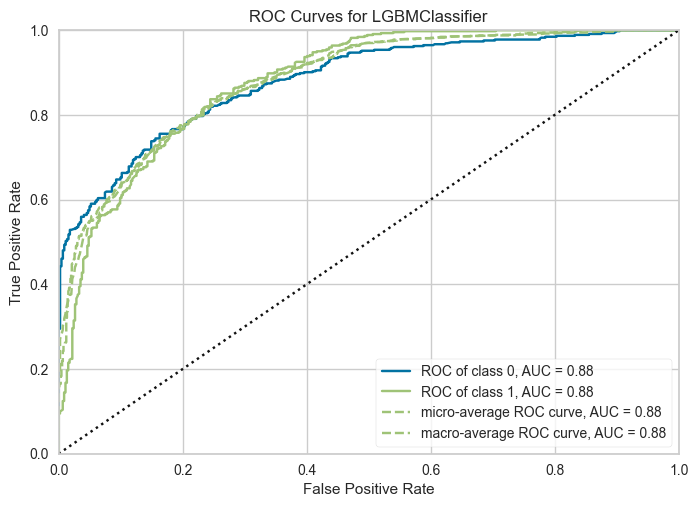

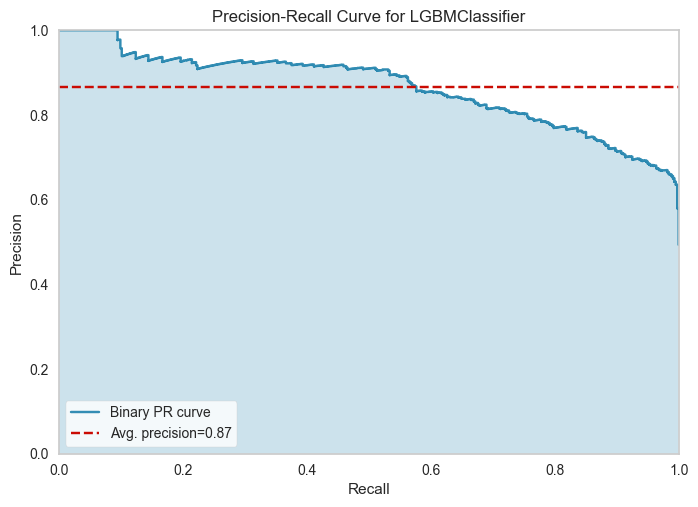

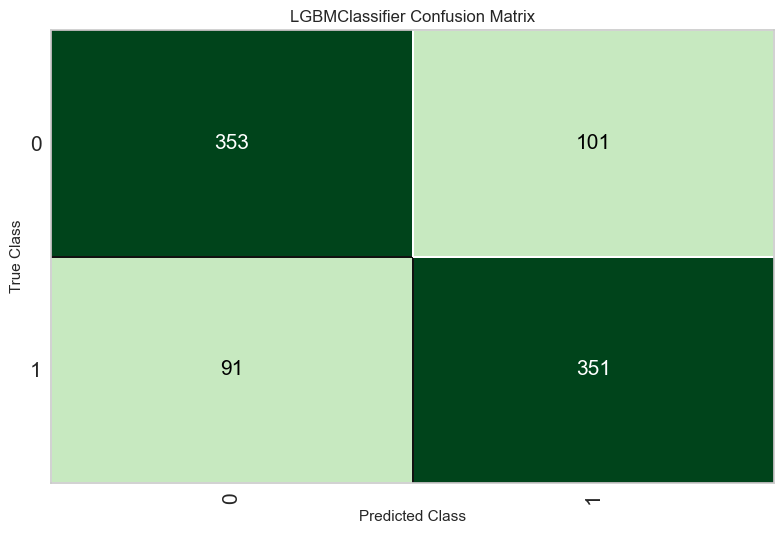

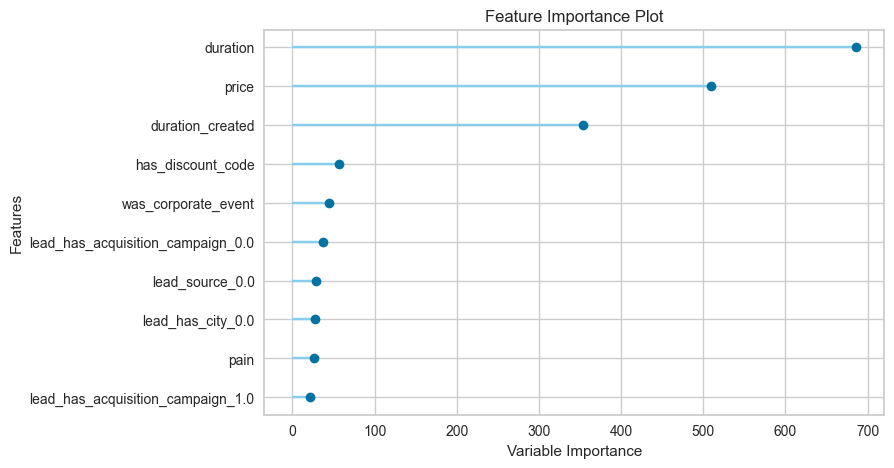

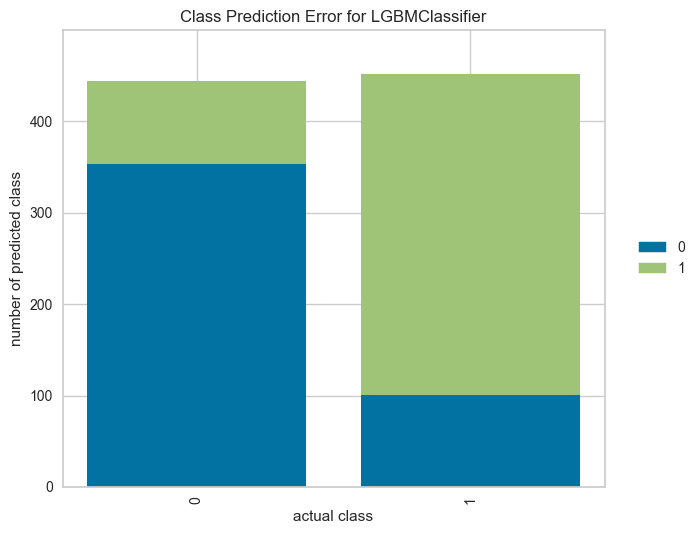

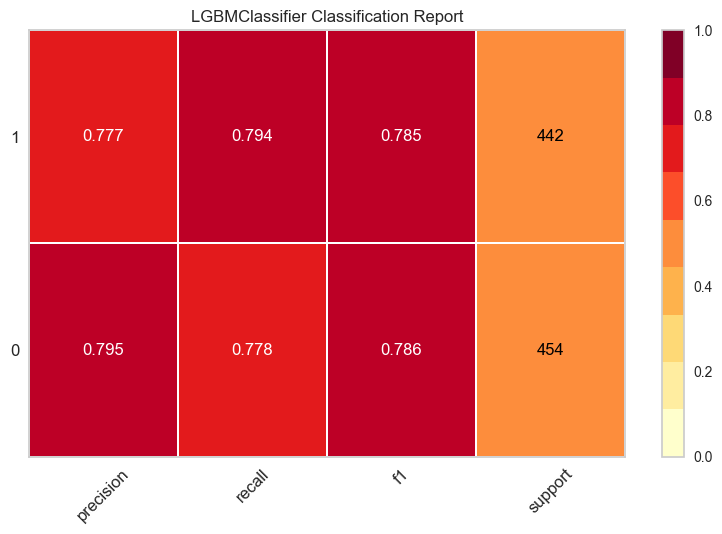

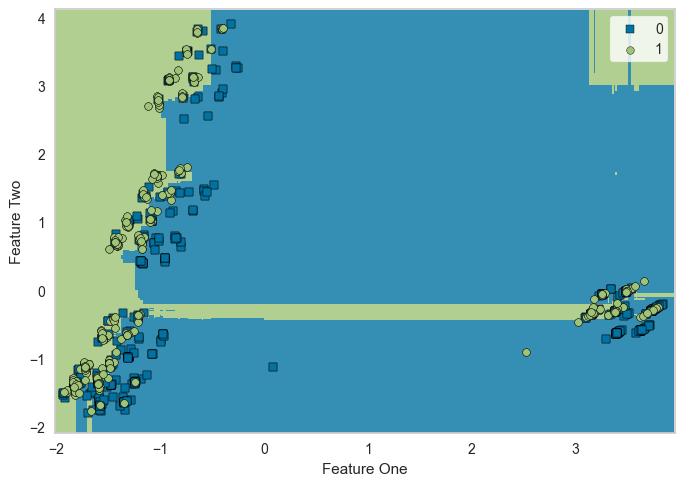

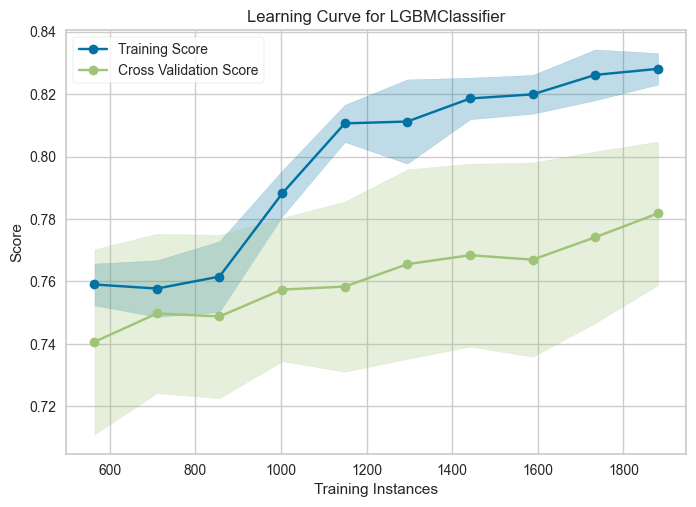

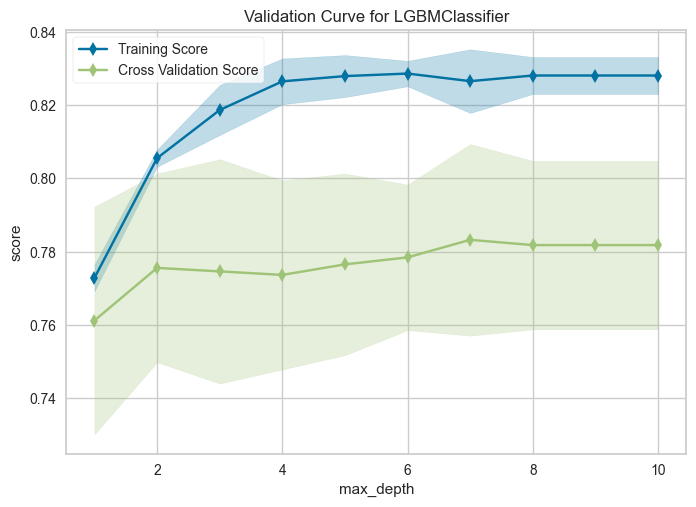

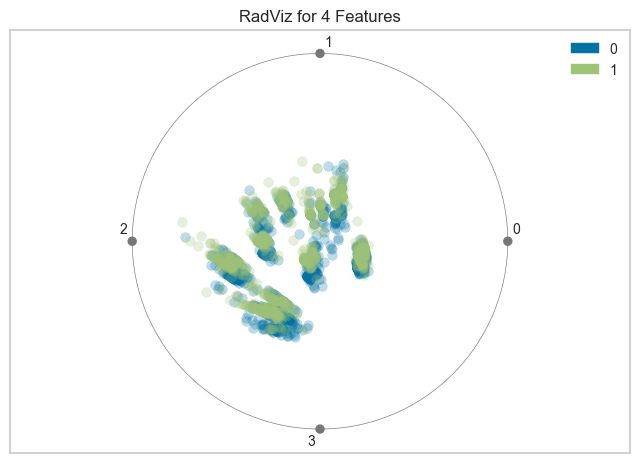

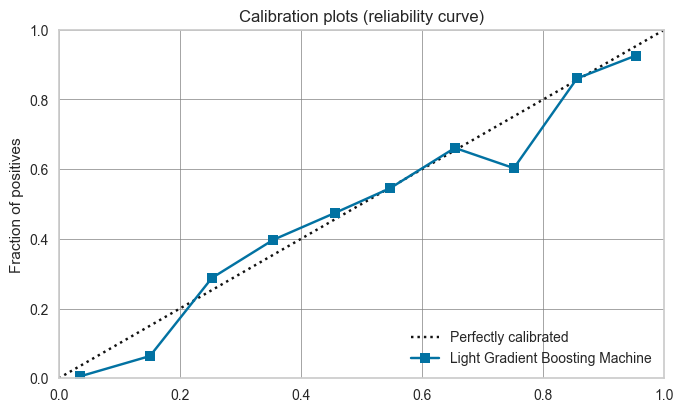

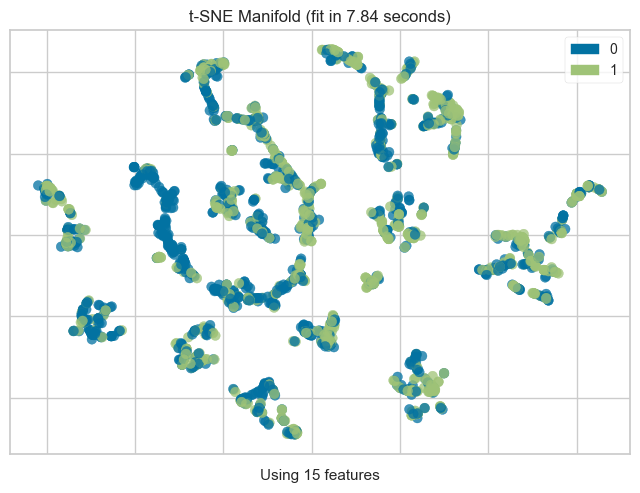

In [8]:
plot_names = [
        'auc', 'pr', 'confusion_matrix', 'feature', 'error',
        'class_report', 'boundary', 'learning', 'vc',
        'dimension', 'calibration', 'manifold'
    ]
for plot_name in plot_names:

    plot = plot_model(tuned_model, plot=plot_name)

In [9]:
proba_pred = predict_model(tuned_model, df_test, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7923,0.8862,0.7991,0.7842,0.7915,0.5847,0.5848


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


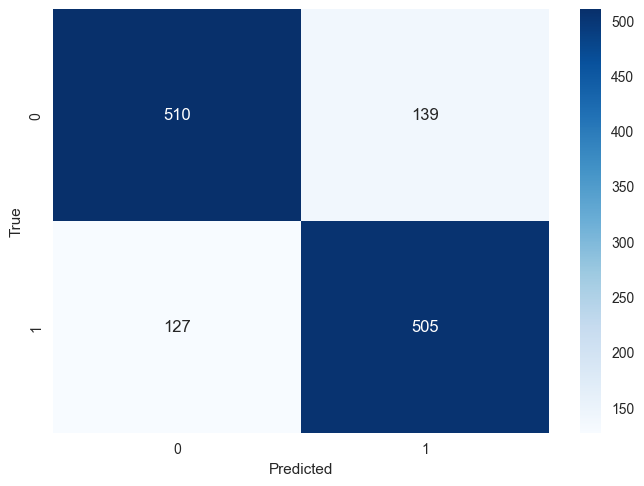

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       649
           1       0.78      0.80      0.79       632

    accuracy                           0.79      1281
   macro avg       0.79      0.79      0.79      1281
weighted avg       0.79      0.79      0.79      1281



In [10]:
from sklearn.metrics import classification_report

def metrics(y_true, y_pred):
    cr = classification_report(y_true, y_pred, output_dict  =True)
    mlflow.log_metric("accuracy", cr.pop("accuracy"))
    for class_or_avg, metrics_dict in cr.items():
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric,value)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    mlflow.log_metric('roc_auc', roc_auc)
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()

metrics(proba_pred['status'], proba_pred['prediction_label'])
print(classification_report(proba_pred['status'], proba_pred['prediction_label']))

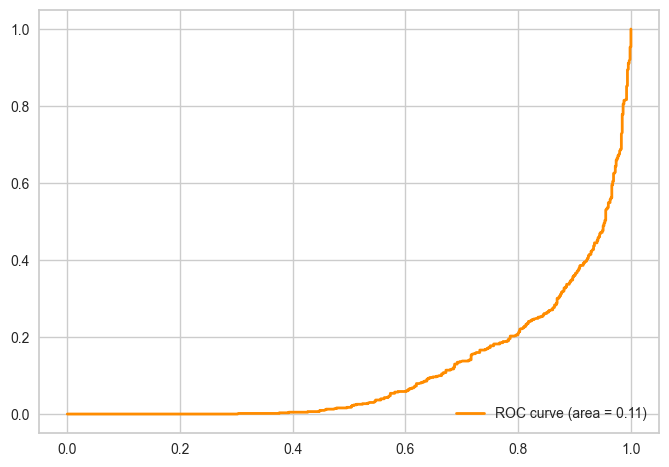

In [12]:
plot_roc_curve(proba_pred['status'], proba_pred['prediction_score_0'])